In [ ]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Reload modules to pick up latest changes
import importlib
if 'config' in sys.modules:
    importlib.reload(sys.modules['config'])
if 'data_loader' in sys.modules:
    importlib.reload(sys.modules['data_loader'])
if 'preprocessing' in sys.modules:
    importlib.reload(sys.modules['preprocessing'])
if 'augmentation' in sys.modules:
    importlib.reload(sys.modules['augmentation'])

# Import custom modules
from config import (
    GERMANY_TRAIN, LOUISIANA_EAST_TRAIN,
    PROCESSED_TRAIN_DIR, CLASS_NAMES, CLASS_COLORS,
    PATCH_SIZE, PATCH_OVERLAP, MIN_FLOOD_PIXELS
)

from data_loader import DatasetLoader, load_tile_data
from preprocessing import ImagePreprocessor, PatchExtractor
from augmentation import get_training_augmentation, DualImageAugmentation

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

%matplotlib inline

print(f"Configuration loaded: MIN_FLOOD_PIXELS = {MIN_FLOOD_PIXELS}")

## 1. Dataset Overview

In [ ]:
# Load dataset loaders
germany_loader = DatasetLoader(GERMANY_TRAIN, 'Germany')
louisiana_loader = DatasetLoader(LOUISIANA_EAST_TRAIN, 'Louisiana-East')

print("Dataset Summary:")
print(f"  Germany tiles: {len(germany_loader.get_tile_list())}")
print(f"  Louisiana-East tiles: {len(louisiana_loader.get_tile_list())}")
print(f"  Total tiles: {len(germany_loader.get_tile_list()) + len(louisiana_loader.get_tile_list())}")

In [ ]:
# Get flood statistics
germany_stats = germany_loader.get_flood_statistics()
louisiana_stats = louisiana_loader.get_flood_statistics()

# Create comparison dataframe
stats_df = pd.DataFrame({
    'Germany': germany_stats,
    'Louisiana-East': louisiana_stats
}).T

print("\nFlood Statistics by Region:")
print(stats_df)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Flooded vs Non-flooded counts
regions = ['Germany', 'Louisiana-East']
flooded = [germany_stats['flooded_count'], louisiana_stats['flooded_count']]
non_flooded = [germany_stats['non_flooded_count'], louisiana_stats['non_flooded_count']]

x = np.arange(len(regions))
width = 0.35

axes[0].bar(x - width/2, flooded, width, label='Flooded', color='#e74c3c')
axes[0].bar(x + width/2, non_flooded, width, label='Non-flooded', color='#2ecc71')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Count')
axes[0].set_title('Flooded vs Non-flooded Road Segments')
axes[0].set_xticks(x)
axes[0].set_xticklabels(regions)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Percentage breakdown
flooded_pct = [germany_stats['flooded_pct'], louisiana_stats['flooded_pct']]
non_flooded_pct = [germany_stats['non_flooded_pct'], louisiana_stats['non_flooded_pct']]

axes[1].bar(x, flooded_pct, width, label='Flooded %', color='#e74c3c')
axes[1].bar(x, non_flooded_pct, width, bottom=flooded_pct, label='Non-flooded %', color='#2ecc71')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Class Distribution (Percentage)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(regions)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nClass Imbalance Detected:")
print(f"   Average flooded ratio: {np.mean(flooded_pct):.1f}%")
print(f"   Addressed through:")
print(f"     - Oversampling flood-positive patches")
print(f"     - Class-weighted loss functions")
print(f"     - Focused augmentation")

## 2. Load and Inspect Sample Tile

In [ ]:
# Load a sample tile from Germany
sample_tile_name = germany_loader.get_tile_list()[0]
print(f"Loading sample tile: {sample_tile_name}")

sample_data = load_tile_data(GERMANY_TRAIN, sample_tile_name, 'Germany')

print(f"\nTile information:")
print(f"  Pre-image shape: {sample_data['pre_image'].shape}")
print(f"  Post-image shape: {sample_data['post_image'].shape}")
print(f"  Mask shape: {sample_data['mask'].shape}")
print(f"  Pre-image dtype: {sample_data['pre_metadata']['dtype']}")
print(f"  Pre-image range: [{sample_data['pre_image'].min():.3f}, {sample_data['pre_image'].max():.3f}]")

# Check mask classes
unique_classes = np.unique(sample_data['mask'])
print(f"\nMask classes present: {unique_classes}")
for cls in unique_classes:
    count = np.sum(sample_data['mask'] == cls)
    pct = (count / sample_data['mask'].size) * 100
    print(f"  Class {cls} ({CLASS_NAMES.get(cls, 'unknown')}): {count} pixels ({pct:.2f}%)")

In [ ]:
# Visualize original tile
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Pre-event
axes[0, 0].imshow(sample_data['pre_image'])
axes[0, 0].set_title('Pre-Event Image', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Post-event
axes[0, 1].imshow(sample_data['post_image'])
axes[0, 1].set_title('Post-Event Image', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Mask
axes[1, 0].imshow(sample_data['mask'], cmap='tab10')
axes[1, 0].set_title('Segmentation Mask', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# Difference
diff = np.abs(sample_data['post_image'] - sample_data['pre_image'])
axes[1, 1].imshow(diff)
axes[1, 1].set_title('Temporal Difference (|Post - Pre|)', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 4. Image Enhancement with CLAHE

In [ ]:
# Initialize preprocessor
preprocessor = ImagePreprocessor(
    apply_clahe=True,
    clahe_clip_limit=2.0,
    clahe_tile_grid_size=(8, 8)
)

# Apply enhancement to pre-image
pre_enhanced = preprocessor.apply_clahe_enhancement(sample_data['pre_image'])
post_enhanced = preprocessor.apply_clahe_enhancement(sample_data['post_image'])

# Compare original vs enhanced
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Pre-event comparison
axes[0, 0].imshow(sample_data['pre_image'])
axes[0, 0].set_title('Pre-Event Original', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(pre_enhanced)
axes[0, 1].set_title('Pre-Event Enhanced (CLAHE)', fontsize=12)
axes[0, 1].axis('off')

# Histogram comparison for pre-event
for i in range(3):
    axes[0, 2].hist(sample_data['pre_image'][:, :, i].flatten(), bins=50, alpha=0.5, label=f'Ch{i} Orig')
    axes[0, 2].hist(pre_enhanced[:, :, i].flatten(), bins=50, alpha=0.5, label=f'Ch{i} Enh', linestyle='--')
axes[0, 2].set_title('Pre-Event Histogram', fontsize=12)
axes[0, 2].set_xlabel('Intensity')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend(fontsize=8)
axes[0, 2].grid(alpha=0.3)

# Post-event comparison
axes[1, 0].imshow(sample_data['post_image'])
axes[1, 0].set_title('Post-Event Original', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(post_enhanced)
axes[1, 1].set_title('Post-Event Enhanced (CLAHE)', fontsize=12)
axes[1, 1].axis('off')

# Histogram comparison for post-event
for i in range(3):
    axes[1, 2].hist(sample_data['post_image'][:, :, i].flatten(), bins=50, alpha=0.5, label=f'Ch{i} Orig')
    axes[1, 2].hist(post_enhanced[:, :, i].flatten(), bins=50, alpha=0.5, label=f'Ch{i} Enh', linestyle='--')
axes[1, 2].set_title('Post-Event Histogram', fontsize=12)
axes[1, 2].set_xlabel('Intensity')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend(fontsize=8)
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCLAHE Enhancement Applied:")
print("  - Improves local contrast")
print("  - Better visibility of flood boundaries")
print("  - Histogram equalization in tiles (8x8)")

## 5. Advanced Preprocessing: Cloud Removal, Deblurring & Geometric Correction

Apply advanced preprocessing techniques to handle common satellite imagery issues.

In [ ]:
# Import advanced image processing libraries
import sys
try:
    from skimage import morphology, filters, exposure, restoration, transform
    from skimage.filters import rank, gaussian
    from skimage.morphology import disk, remove_small_objects, remove_small_holes
    from scipy import ndimage
    from scipy.signal import convolve2d
    print("✓ Advanced image processing libraries loaded successfully")
except ImportError as e:
    print(f"Installing required libraries: {e}")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "scikit-image", "scipy"])
    from skimage import morphology, filters, exposure, restoration, transform
    from skimage.filters import rank, gaussian
    from skimage.morphology import disk, remove_small_objects, remove_small_holes
    from scipy import ndimage
    from scipy.signal import convolve2d
    print("✓ Libraries installed and loaded")

print("\nAdvanced preprocessing methods available:")
print("  1. Multi-stage cloud detection (brightness + texture + saturation)")
print("  2. Morphological cloud refinement")
print("  3. Advanced inpainting (Navier-Stokes + Telea)")
print("  4. Wiener deconvolution for deblurring")
print("  5. Richardson-Lucy deconvolution")
print("  6. Unsharp masking with adaptive strength")
print("  7. CLAHE enhancement per channel")

In [ ]:
def create_synthetic_degraded_image(clean_image):
    """
    Create a heavily degraded version to demonstrate preprocessing capabilities
    Adds realistic clouds, haze, and blur
    """
    degraded = clean_image.copy()
    h, w = degraded.shape[:2]
    
    # 1. Add atmospheric haze (reduces contrast and adds blue tint)
    haze_strength = 0.5
    haze_color = np.array([0.7, 0.75, 0.85])  # Blueish-white
    degraded = degraded * (1 - haze_strength) + haze_color * haze_strength
    
    # 2. Add realistic cloud patches
    num_clouds = np.random.randint(8, 15)
    for _ in range(num_clouds):
        # Random cloud center
        cx, cy = np.random.randint(0, w), np.random.randint(0, h)
        
        # Cloud size
        cloud_w = np.random.randint(80, 200)
        cloud_h = np.random.randint(60, 150)
        
        # Create cloud mask with soft edges (Gaussian falloff)
        y_coords, x_coords = np.ogrid[:h, :w]
        cloud_mask = np.exp(-((x_coords - cx)**2 / (2 * cloud_w**2) + 
                             (y_coords - cy)**2 / (2 * cloud_h**2)))
        
        # Cloud color (bright white with slight variation)
        cloud_color = np.array([0.85, 0.88, 0.95]) + np.random.uniform(-0.05, 0.05, 3)
        cloud_opacity = np.random.uniform(0.5, 0.9)
        
        # Blend cloud
        for c in range(3):
            degraded[:, :, c] = (degraded[:, :, c] * (1 - cloud_mask * cloud_opacity) + 
                                cloud_color[c] * cloud_mask * cloud_opacity)
    
    # 3. Add motion blur (simulating camera/satellite motion)
    kernel_size = 15
    motion_kernel = np.zeros((kernel_size, kernel_size))
    motion_kernel[kernel_size // 2, :] = 1.0 / kernel_size
    
    blurred = np.zeros_like(degraded)
    for c in range(3):
        blurred[:, :, c] = convolve2d(degraded[:, :, c], motion_kernel, mode='same', boundary='symm')
    degraded = blurred
    
    # 4. Add Gaussian noise
    noise = np.random.normal(0, 0.03, degraded.shape)
    degraded = degraded + noise
    
    # 5. Reduce overall sharpness
    degraded = gaussian(degraded, sigma=1.5, channel_axis=2)
    
    return np.clip(degraded, 0, 1)


def advanced_cloud_removal(image, aggressive=True):
    """
    State-of-the-art cloud detection and removal
    """
    img_uint8 = (image * 255).astype(np.uint8)
    h, w = img_uint8.shape[:2]
    
    # === MULTI-STAGE CLOUD DETECTION ===
    
    # Stage 1: Brightness analysis
    gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
    if aggressive:
        bright_mask = gray > 160  # Lower threshold for more detection
    else:
        bright_mask = gray > 180
    
    # Stage 2: Blue channel analysis (clouds are blue-white)
    blue_excess = img_uint8[:, :, 2].astype(float) - (img_uint8[:, :, 0].astype(float) + img_uint8[:, :, 1].astype(float)) / 2
    blue_mask = blue_excess > 10
    
    # Stage 3: Texture analysis (clouds have uniform texture)
    selem = disk(7)
    entropy_img = rank.entropy(gray, selem)
    texture_mask = entropy_img < np.percentile(entropy_img, 25)
    
    # Stage 4: Saturation analysis (clouds have low saturation)
    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
    low_sat_mask = hsv[:, :, 1] < 40
    
    # Stage 5: Value analysis (clouds are bright in HSV)
    high_value_mask = hsv[:, :, 2] > 200
    
    # Combine all stages
    cloud_mask = (bright_mask & blue_mask) | (bright_mask & low_sat_mask & texture_mask) | (high_value_mask & low_sat_mask)
    cloud_mask = cloud_mask.astype(np.uint8) * 255
    
    # === MORPHOLOGICAL REFINEMENT ===
    
    # Remove small false positives
    cloud_mask_binary = cloud_mask > 0
    cloud_mask_binary = remove_small_objects(cloud_mask_binary, min_size=100, connectivity=2)
    cloud_mask_binary = remove_small_holes(cloud_mask_binary, area_threshold=200)
    
    # Dilate to ensure full cloud coverage
    selem_dilate = disk(5 if aggressive else 3)
    cloud_mask_binary = morphology.dilation(cloud_mask_binary, selem_dilate)
    
    cloud_mask_final = (cloud_mask_binary * 255).astype(np.uint8)
    
    # === ADVANCED INPAINTING ===
    
    if np.sum(cloud_mask_final > 0) > 200:
        # Method 1: Navier-Stokes (better for texture preservation)
        inpainted_ns = cv2.inpaint(img_uint8, cloud_mask_final, 10, cv2.INPAINT_NS)
        
        # Method 2: Fast Marching (better for structure)
        inpainted_fm = cv2.inpaint(img_uint8, cloud_mask_final, 7, cv2.INPAINT_TELEA)
        
        # Blend both methods
        result = cv2.addWeighted(inpainted_ns, 0.6, inpainted_fm, 0.4, 0)
        
        # Apply bilateral filter for smooth transitions
        result = cv2.bilateralFilter(result, 7, 75, 75)
    else:
        result = img_uint8
    
    return result.astype(np.float32) / 255.0, cloud_mask_final.astype(np.float32) / 255.0


def advanced_deblurring(image, strength='high'):
    """
    Advanced deblurring using multiple state-of-the-art methods
    """
    img_uint8 = (image * 255).astype(np.uint8)
    
    # === METHOD 1: WIENER DECONVOLUTION ===
    try:
        # Create motion blur PSF
        kernel_size = 11
        psf = np.zeros((kernel_size, kernel_size))
        psf[kernel_size // 2, :] = 1.0
        psf = psf / psf.sum()
        
        # Apply Wiener deconvolution
        deconvolved = np.zeros_like(image)
        for c in range(3):
            deconv_channel = restoration.wiener(image[:, :, c], psf, balance=0.05)
            deconvolved[:, :, c] = np.clip(deconv_channel, 0, 1)
        
        deconv_uint8 = (deconvolved * 255).astype(np.uint8)
    except:
        deconv_uint8 = img_uint8
    
    # === METHOD 2: RICHARDSON-LUCY DECONVOLUTION ===
    try:
        rl_deconvolved = np.zeros_like(image)
        for c in range(3):
            rl_channel = restoration.richardson_lucy(image[:, :, c], psf, num_iter=15)
            rl_deconvolved[:, :, c] = np.clip(rl_channel, 0, 1)
        
        rl_uint8 = (rl_deconvolved * 255).astype(np.uint8)
    except:
        rl_uint8 = img_uint8
    
    # === METHOD 3: ENHANCED UNSHARP MASKING ===
    gaussian_blur = cv2.GaussianBlur(img_uint8, (9, 9), 2.0)
    if strength == 'high':
        unsharp = cv2.addWeighted(img_uint8, 2.5, gaussian_blur, -1.5, 0)
    else:
        unsharp = cv2.addWeighted(img_uint8, 2.0, gaussian_blur, -1.0, 0)
    
    # === METHOD 4: EDGE ENHANCEMENT ===
    gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
    
    # Sobel edge detection
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    edges = np.sqrt(sobelx**2 + sobely**2)
    edges = np.clip(edges, 0, 255).astype(np.uint8)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    
    edge_enhanced = cv2.addWeighted(img_uint8, 1.0, edges_colored, 0.4, 0)
    
    # === METHOD 5: ADAPTIVE CLAHE ===
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    clahe_enhanced = np.zeros_like(img_uint8)
    for c in range(3):
        clahe_enhanced[:, :, c] = clahe.apply(img_uint8[:, :, c])
    
    # === BLEND ALL METHODS ===
    # Wiener (25%) + RL (20%) + Unsharp (30%) + Edge (15%) + CLAHE (10%)
    result = cv2.addWeighted(deconv_uint8, 0.25, rl_uint8, 0.20, 0)
    result = cv2.addWeighted(result, 1.0, unsharp, 0.30, 0)
    result = cv2.addWeighted(result, 1.0, edge_enhanced, 0.15, 0)
    result = cv2.addWeighted(result, 0.9, clahe_enhanced, 0.10, 0)
    
    # === FINAL SHARPENING ===
    laplacian = cv2.Laplacian(cv2.cvtColor(result, cv2.COLOR_RGB2GRAY), cv2.CV_64F, ksize=3)
    laplacian_colored = cv2.cvtColor(np.abs(laplacian).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    result = cv2.addWeighted(result, 1.0, laplacian_colored, 0.20, 0)
    
    return np.clip(result.astype(np.float32) / 255.0, 0, 1)


def calculate_quality_metrics(image):
    """Calculate image quality metrics"""
    img_uint8 = (image * 255).astype(np.uint8)
    gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
    
    # Sharpness (Laplacian variance)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    
    # Contrast (standard deviation)
    contrast = np.std(image)
    
    # Brightness
    brightness = np.mean(image)
    
    # Edge density
    edges = cv2.Canny(gray, 50, 150)
    edge_density = np.sum(edges > 0) / edges.size
    
    return {
        'sharpness': laplacian_var,
        'contrast': contrast,
        'brightness': brightness,
        'edge_density': edge_density
    }

print("✓ Advanced preprocessing functions defined")

In [ ]:
# Apply advanced preprocessing to both pre-event and post-event images
print("Applying advanced preprocessing to BOTH pre-event and post-event images...")
print("="*80)

# Pre-event processing
print("\n[PRE-EVENT IMAGE]")
pre_degraded = create_synthetic_degraded_image(sample_data['pre_image'])
pre_cloud_removed, pre_cloud_mask = advanced_cloud_removal(pre_degraded, aggressive=True)
pre_enhanced = advanced_deblurring(pre_cloud_removed, strength='high')
pre_cloud_cov = np.mean(pre_cloud_mask) * 100

# Calculate metrics
pre_orig_metrics = calculate_quality_metrics(sample_data['pre_image'])
pre_deg_metrics = calculate_quality_metrics(pre_degraded)
pre_enh_metrics = calculate_quality_metrics(pre_enhanced)

print(f"  Cloud coverage detected: {pre_cloud_cov:.1f}%")
print(f"  Sharpness improvement: {((pre_enh_metrics['sharpness']/pre_deg_metrics['sharpness']-1)*100):+.1f}%")
print(f"  Contrast improvement:  {((pre_enh_metrics['contrast']/pre_deg_metrics['contrast']-1)*100):+.1f}%")

# Post-event processing
print("\n[POST-EVENT IMAGE]")
post_degraded = create_synthetic_degraded_image(sample_data['post_image'])
post_cloud_removed, post_cloud_mask = advanced_cloud_removal(post_degraded, aggressive=True)
post_enhanced = advanced_deblurring(post_cloud_removed, strength='high')
post_cloud_cov = np.mean(post_cloud_mask) * 100

# Calculate metrics
post_orig_metrics = calculate_quality_metrics(sample_data['post_image'])
post_deg_metrics = calculate_quality_metrics(post_degraded)
post_enh_metrics = calculate_quality_metrics(post_enhanced)

print(f"  Cloud coverage detected: {post_cloud_cov:.1f}%")
print(f"  Sharpness improvement: {((post_enh_metrics['sharpness']/post_deg_metrics['sharpness']-1)*100):+.1f}%")
print(f"  Contrast improvement:  {((post_enh_metrics['contrast']/post_deg_metrics['contrast']-1)*100):+.1f}%")

print("\n" + "="*80)
print("Preprocessing complete for both images")
print("="*80)

In [ ]:
# Comprehensive visualization: Pre-event & Post-event (Original -> Degraded -> Enhanced)
fig, axes = plt.subplots(6, 3, figsize=(18, 36))

# Column headers
axes[0, 0].text(0.5, 0.5, 'ORIGINAL\n(Clean)', ha='center', va='center', 
                fontsize=16, fontweight='bold', color='green',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
axes[0, 0].axis('off')

axes[0, 1].text(0.5, 0.5, 'DEGRADED\n(Clouds + Blur)', ha='center', va='center', 
                fontsize=16, fontweight='bold', color='red',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))
axes[0, 1].axis('off')

axes[0, 2].text(0.5, 0.5, 'ENHANCED\n(Preprocessed)', ha='center', va='center', 
                fontsize=16, fontweight='bold', color='darkgreen',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
axes[0, 2].axis('off')

# === PRE-EVENT IMAGE ===

# Row 1: Pre-Event images
axes[1, 0].imshow(sample_data['pre_image'])
axes[1, 0].set_title('Pre-Event Original\n(Clean Baseline)', fontsize=13, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(pre_degraded)
axes[1, 1].set_title(f'Pre-Event Degraded\n(Sharpness: {pre_deg_metrics["sharpness"]:.1f})', 
                     fontsize=13, color='darkred', fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(pre_enhanced)
axes[1, 2].set_title(f'Pre-Event Enhanced\n(Sharpness: {pre_enh_metrics["sharpness"]:.1f} | +{((pre_enh_metrics["sharpness"]/pre_deg_metrics["sharpness"]-1)*100):.0f}%)', 
                     fontsize=13, color='darkgreen', fontweight='bold')
axes[1, 2].axis('off')

# Row 2: Pre-Event cloud masks and differences
axes[2, 0].text(0.5, 0.5, f"Original Metrics:\nSharpness: {pre_orig_metrics['sharpness']:.1f}\nContrast: {pre_orig_metrics['contrast']:.3f}\nEdge Density: {pre_orig_metrics['edge_density']:.3f}",
                ha='center', va='center', fontsize=11, family='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
axes[2, 0].axis('off')

axes[2, 1].imshow(pre_cloud_mask, cmap='Reds', vmin=0, vmax=1)
axes[2, 1].set_title(f'Cloud Mask\n({pre_cloud_cov:.1f}% coverage)', fontsize=12, color='red')
axes[2, 1].axis('off')

diff_pre = np.abs(pre_degraded - pre_enhanced)
axes[2, 2].imshow(diff_pre)
axes[2, 2].set_title('Preprocessing Changes\n(Difference Map)', fontsize=12)
axes[2, 2].axis('off')

# === POST-EVENT IMAGE ===

# Row 3: Separator
for col in range(3):
    axes[3, col].text(0.5, 0.5, '━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━', 
                      ha='center', va='center', fontsize=14, color='gray')
    axes[3, col].axis('off')

# Row 4: Post-Event images
axes[4, 0].imshow(sample_data['post_image'])
axes[4, 0].set_title('Post-Event Original\n(Clean Baseline)', fontsize=13, fontweight='bold')
axes[4, 0].axis('off')

axes[4, 1].imshow(post_degraded)
axes[4, 1].set_title(f'Post-Event Degraded\n(Sharpness: {post_deg_metrics["sharpness"]:.1f})', 
                     fontsize=13, color='darkred', fontweight='bold')
axes[4, 1].axis('off')

axes[4, 2].imshow(post_enhanced)
axes[4, 2].set_title(f'Post-Event Enhanced\n(Sharpness: {post_enh_metrics["sharpness"]:.1f} | +{((post_enh_metrics["sharpness"]/post_deg_metrics["sharpness"]-1)*100):.0f}%)', 
                     fontsize=13, color='darkgreen', fontweight='bold')
axes[4, 2].axis('off')

# Row 5: Post-Event cloud masks and differences
axes[5, 0].text(0.5, 0.5, f"Original Metrics:\nSharpness: {post_orig_metrics['sharpness']:.1f}\nContrast: {post_orig_metrics['contrast']:.3f}\nEdge Density: {post_orig_metrics['edge_density']:.3f}",
                ha='center', va='center', fontsize=11, family='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
axes[5, 0].axis('off')

axes[5, 1].imshow(post_cloud_mask, cmap='Reds', vmin=0, vmax=1)
axes[5, 1].set_title(f'Cloud Mask\n({post_cloud_cov:.1f}% coverage)', fontsize=12, color='red')
axes[5, 1].axis('off')

diff_post = np.abs(post_degraded - post_enhanced)
axes[5, 2].imshow(diff_post)
axes[5, 2].set_title('Preprocessing Changes\n(Difference Map)', fontsize=12)
axes[5, 2].axis('off')

plt.suptitle('Advanced Preprocessing: Cloud Removal + Deblurring with scikit-image\nOriginal → Synthetic Degradation → Enhanced (Pre & Post Event)', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print comprehensive summary
print("\n" + "="*80)
print("PREPROCESSING EFFECTIVENESS SUMMARY")
print("="*80)
print("\n✓ PRE-EVENT IMAGE:")
print(f"    Sharpness improvement: {((pre_enh_metrics['sharpness']/pre_deg_metrics['sharpness']-1)*100):+.1f}%")
print(f"    Contrast improvement:  {((pre_enh_metrics['contrast']/pre_deg_metrics['contrast']-1)*100):+.1f}%")
print(f"    Edge density improvement: {((pre_enh_metrics['edge_density']/pre_deg_metrics['edge_density']-1)*100):+.1f}%")
print(f"    Cloud coverage removed: {pre_cloud_cov:.1f}%")

print("\n✓ POST-EVENT IMAGE:")
print(f"    Sharpness improvement: {((post_enh_metrics['sharpness']/post_deg_metrics['sharpness']-1)*100):+.1f}%")
print(f"    Contrast improvement:  {((post_enh_metrics['contrast']/post_deg_metrics['contrast']-1)*100):+.1f}%")
print(f"    Edge density improvement: {((post_enh_metrics['edge_density']/post_deg_metrics['edge_density']-1)*100):+.1f}%")
print(f"    Cloud coverage removed: {post_cloud_cov:.1f}%")

print("\n" + "="*80)
print("TECHNIQUES APPLIED:")
print("  ✓ Multi-stage cloud detection (brightness + blue excess + texture + saturation + value)")
print("  ✓ Morphological refinement (remove_small_objects + remove_small_holes + dilation)")
print("  ✓ Dual inpainting (Navier-Stokes 60% + Telea 40%)")
print("  ✓ Wiener deconvolution (25% weight)")
print("  ✓ Richardson-Lucy deconvolution (20% weight)")
print("  ✓ Enhanced unsharp masking (30% weight, 2.5/-1.5)")
print("  ✓ Sobel edge enhancement (15% weight)")
print("  ✓ Adaptive CLAHE (10% weight, clip=4.0)")
print("  ✓ Laplacian sharpening (20% weight)")
print("="*80)

## 6. Quality Check

In [ ]:
# Check image quality
quality_pre = preprocessor.check_image_quality(sample_data['pre_image'])
quality_post = preprocessor.check_image_quality(sample_data['post_image'])

print("Pre-Event Quality Metrics:")
for key, value in quality_pre.items():
    print(f"  {key}: {value}")

print("\nPost-Event Quality Metrics:")
for key, value in quality_post.items():
    print(f"  {key}: {value}")

# Visualize quality metrics
metrics = ['valid_ratio', 'cloud_ratio', 'dark_ratio', 'mean_intensity', 'std_intensity']
pre_values = [quality_pre[m] for m in metrics]
post_values = [quality_post[m] for m in metrics]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, pre_values, width, label='Pre-Event', color='#3498db')
ax.bar(x + width/2, post_values, width, label='Post-Event', color='#e74c3c')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Image Quality Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Patch Extraction with Smart Sampling

In [ ]:
# Initialize patch extractor with updated threshold
patch_extractor = PatchExtractor(
    patch_size=PATCH_SIZE,
    overlap=PATCH_OVERLAP,
    min_flood_pixels=MIN_FLOOD_PIXELS  # Now 2621 pixels (~1% of patch)
)

print(f"Patch extractor configuration:")
print(f"  Patch size: {PATCH_SIZE}x{PATCH_SIZE}")
print(f"  Overlap: {PATCH_OVERLAP}")
print(f"  Min flood pixels: {MIN_FLOOD_PIXELS} ({(MIN_FLOOD_PIXELS/(PATCH_SIZE**2))*100:.2f}% of patch)")

# Concatenate pre and post images
combined_image = np.concatenate([pre_enhanced, post_enhanced], axis=2)
print(f"\nCombined image shape: {combined_image.shape} (6 channels: 3 pre + 3 post)")

# Extract patches (without oversampling for demonstration)
patches = patch_extractor.extract_patches(
    combined_image,
    mask=sample_data['mask'],
    oversample_flood=False  # Disabled to show true distribution
)

print(f"\nExtracted {len(patches)} patches")

# Count flood-positive patches
flood_positive = [p for p in patches if p['is_flood_positive']]
print(f"  Flood-positive patches: {len(flood_positive)}")
print(f"  Non-flood patches: {len(patches) - len(flood_positive)}")
print(f"  Flood ratio: {len(flood_positive)/len(patches)*100:.1f}%")

In [ ]:
print("Mask shape:", sample_data['mask'].shape)
print("Unique classes in mask:", np.unique(sample_data['mask']))
print("Mask value counts:")
unique, counts = np.unique(sample_data['mask'], return_counts=True)
for cls, count in zip(unique, counts):
    pct = (count / sample_data['mask'].size) * 100
    print(f"  Class {cls} ({CLASS_NAMES.get(cls, 'unknown')}): {count:,} pixels ({pct:.2f}%)")

# Check if mask has any flood-related classes (2, 3, 4, 5)
flood_related_pixels = np.sum(sample_data['mask'] > 1)
print(f"\nTotal flood-related pixels (class > 1): {flood_related_pixels:,}")
print(f"Percentage: {(flood_related_pixels / sample_data['mask'].size) * 100:.2f}%")

In [ ]:
# Try loading different tiles to find one with mixed flood/non-flood patches
print("Testing different tiles to find varied flood distribution:")
print("="*60)

for idx in range(min(5, len(germany_loader.get_tile_list()))):
    tile_name = germany_loader.get_tile_list()[idx]
    tile_data = load_tile_data(GERMANY_TRAIN, tile_name, 'Germany')
    
    # Calculate flood percentage
    flood_px = np.sum((tile_data['mask'] == 2) | (tile_data['mask'] == 3) | (tile_data['mask'] == 4))
    total_px = tile_data['mask'].size
    flood_pct = (flood_px / total_px) * 100
    
    print(f"\nTile {idx}: {tile_name}")
    print(f"  Flood pixels: {flood_px:,} ({flood_pct:.2f}%)")
    print(f"  Classes present: {np.unique(tile_data['mask'])}")
    
    # If this tile has moderate flooding (2-15%), use it for demo
    if 2.0 <= flood_pct <= 15.0:
        print(f" Good candidate for mixed flood/non-flood patches")
        break

In [ ]:
print("\n" + "="*60)
print("Testing patch extraction with different thresholds:")
print("="*60)

for threshold in [100, 2621, 5000, 10000, 20000]:
    test_extractor = PatchExtractor(
        patch_size=PATCH_SIZE,
        overlap=PATCH_OVERLAP,
        min_flood_pixels=threshold
    )
    
    test_patches = test_extractor.extract_patches(
        combined_image,
        mask=sample_data['mask'],
        oversample_flood=False  # Disable oversampling for clarity
    )
    
    flood_count = sum(1 for p in test_patches if p['is_flood_positive'])
    non_flood_count = len(test_patches) - flood_count
    
    print(f"\nThreshold: {threshold} pixels ({(threshold/(PATCH_SIZE**2))*100:.2f}% of patch)")
    print(f"  Total patches: {len(test_patches)}")
    print(f"  Flood-positive: {flood_count}")
    print(f"  Non-flood: {non_flood_count}")
    print(f"  Flood ratio: {(flood_count/len(test_patches))*100:.1f}%")

In [ ]:
print("\nPatch-level flood analysis:")
for i, patch in enumerate(patches):
    flood_px = patch['flood_pixels']
    total_px = PATCH_SIZE * PATCH_SIZE
    flood_pct = (flood_px / total_px) * 100
    print(f"  Patch {i}: {flood_px} flood pixels ({flood_pct:.2f}%)")

print(f"\nPatch size: {PATCH_SIZE}x{PATCH_SIZE} = {PATCH_SIZE*PATCH_SIZE:,} pixels")
print(f"Min flood pixels threshold: {patch_extractor.min_flood_pixels}")
print(f"Min flood percentage needed: {(patch_extractor.min_flood_pixels / (PATCH_SIZE*PATCH_SIZE)) * 100:.2f}%")

In [ ]:
# Visualize sample patches
n_samples = min(8, len(patches))
sample_patches = np.random.choice(patches, n_samples, replace=False)

fig, axes = plt.subplots(4, n_samples, figsize=(n_samples*3, 12))

for i, patch in enumerate(sample_patches):
    # Pre-event (first 3 channels)
    pre_patch = patch['image'][:, :, :3]
    axes[0, i].imshow(pre_patch)
    axes[0, i].set_title(f"Patch {i}\nPre-Event", fontsize=10)
    axes[0, i].axis('off')
    
    # Post-event (last 3 channels)
    post_patch = patch['image'][:, :, 3:6]
    axes[1, i].imshow(post_patch)
    axes[1, i].set_title('Post-Event', fontsize=10)
    axes[1, i].axis('off')
    
    # Mask
    axes[2, i].imshow(patch['mask'], cmap='tab10', vmin=0, vmax=5)
    axes[2, i].set_title('Mask', fontsize=10)
    axes[2, i].axis('off')
    
    # Difference
    diff_patch = np.abs(post_patch - pre_patch)
    axes[3, i].imshow(diff_patch)
    flood_status = 'FLOOD' if patch['is_flood_positive'] else 'OK'
    axes[3, i].set_title(f"Difference\n{flood_status}", fontsize=10)
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()

## 8. Class Distribution Analysis

In [ ]:
# Analyze class distribution across all patches
class_totals = {i: 0 for i in range(7)}  # Classes 0-6

for patch in patches:
    for cls, count in patch.get('class_distribution', {}).items():
        class_totals[int(cls)] += count

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
classes = list(class_totals.keys())
counts = list(class_totals.values())
labels = [f"{CLASS_NAMES.get(c, f'Class {c}')}\n{counts[i]:,}" for i, c in enumerate(classes)]

# Convert RGB colors (0-255) to hex format, normalizing to 0-1 range
colors = []
for cls in classes:
    rgb = CLASS_COLORS.get(cls, [128, 128, 128])
    # Normalize RGB values from 0-255 to 0-1
    r, g, b = [val/255.0 for val in rgb]
    colors.append((r, g, b))

axes[0].pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Class Distribution (Pixel Count)', fontsize=14, fontweight='bold')

# Bar chart
axes[1].bar(classes, counts, color=colors)
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Pixel Count', fontsize=12)
axes[1].set_title('Class Distribution (Bar Chart)', fontsize=14, fontweight='bold')
axes[1].set_xticks(classes)
axes[1].set_xticklabels([CLASS_NAMES.get(c, f'C{c}') for c in classes], rotation=45, ha='right')
axes[1].grid(alpha=0.3, axis='y')

# Add counts on bars
for i, (cls, count) in enumerate(zip(classes, counts)):
    axes[1].text(cls, count, f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nClass Imbalance Summary:")
total_pixels = sum(counts)
for cls, count in zip(classes, counts):
    pct = (count / total_pixels) * 100
    print(f"  {CLASS_NAMES.get(cls, f'Class {cls}')}: {count:,} pixels ({pct:.2f}%)")

## 9. Data Augmentation Preview

In [ ]:
# Get training augmentation
train_aug = get_training_augmentation(image_size=PATCH_SIZE)

# Select a flood-positive patch for demonstration
demo_patch = flood_positive[0] if len(flood_positive) > 0 else patches[0]
demo_image = demo_patch['image'][:, :, :3]  # Use pre-event for demo
demo_mask = demo_patch['mask']

# Apply augmentation multiple times
n_aug = 6
fig, axes = plt.subplots(2, n_aug, figsize=(n_aug*3, 6))

for i in range(n_aug):
    augmented = train_aug(image=demo_image, mask=demo_mask)
    
    axes[0, i].imshow(augmented['image'])
    axes[0, i].set_title(f'Aug {i+1} - Image', fontsize=10)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(augmented['mask'], cmap='tab10', vmin=0, vmax=5)
    axes[1, i].set_title(f'Aug {i+1} - Mask', fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nAugmentations include:")
print("  - Horizontal/Vertical flips")
print("  - Random rotations (90 degrees)")
print("  - Shift, scale, rotate")
print("  - Brightness/contrast adjustments")
print("  - Gaussian noise and blur")
print("  - Random fog and shadows")
print("  - Grid dropout")

## 10. Run Full Preprocessing Pipeline

This section runs the complete preprocessing pipeline on both regions.

In [ ]:
# Import preprocessing script
import subprocess

print("Starting full preprocessing pipeline...")
print("This may take 30-60 minutes depending on dataset size.")
print("\nProcessing:")
print("  1. Load all tiles from Germany and Louisiana-East")
print("  2. Apply quality checks")
print("  3. Apply CLAHE enhancement")
print("  4. Extract patches with smart sampling")
print("  5. Oversample flood-positive patches")
print("  6. Create geo-stratified train/val/test splits")
print("  7. Export to dataset/processed/")
print("\n" + "="*80)

In [ ]:
# Execute the preprocessing script

#%run ../src/run_preprocessing.py

## 11. Export Metadata Files

After preprocessing is complete, generate metadata files (JSON, Pickle, CSV) for all splits.

In [ ]:
# Run metadata export script
%run ../src/export_metadata.py

## 12. Validate Processed Data

After preprocessing and metadata export are complete, validate the output.

In [ ]:
# Check if processed data exists
if PROCESSED_TRAIN_DIR.exists():
    print("Processed data directory exists")
    
    # Count files
    train_images = list((PROCESSED_TRAIN_DIR / 'images').glob('*.npy'))
    train_masks = list((PROCESSED_TRAIN_DIR / 'masks').glob('*.npy'))
    
    print(f"\nTraining set:")
    print(f"  Images: {len(train_images)}")
    print(f"  Masks: {len(train_masks)}")
    
    # Load metadata
    metadata_path = PROCESSED_TRAIN_DIR / 'metadata' / 'train_metadata.json'
    if metadata_path.exists():
        import json
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        print(f"  Metadata entries: {len(metadata)}")
        
        # Count flood-positive
        flood_count = sum(1 for m in metadata if m['is_flood_positive'])
        print(f"  Flood-positive patches: {flood_count} ({flood_count/len(metadata)*100:.1f}%)")
    
    # Load and display a sample
    if len(train_images) > 0:
        sample_img = np.load(train_images[0])
        sample_mask = np.load(train_masks[0])
        
        print(f"\nSample patch:")
        print(f"  Image shape: {sample_img.shape}")
        print(f"  Mask shape: {sample_mask.shape}")
        print(f"  Image range: [{sample_img.min():.3f}, {sample_img.max():.3f}]")
        print(f"  Mask classes: {np.unique(sample_mask)}")
        
        # Visualize
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(sample_img[:, :, :3])  # Pre-event
        axes[0].set_title('Pre-Event (Processed)', fontsize=12)
        axes[0].axis('off')
        
        axes[1].imshow(sample_img[:, :, 3:6])  # Post-event
        axes[1].set_title('Post-Event (Processed)', fontsize=12)
        axes[1].axis('off')
        
        axes[2].imshow(sample_mask, cmap='tab10')
        axes[2].set_title('Mask', fontsize=12)
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("Processed data not found. Run preprocessing first.")

## 13. Compare Raw vs Processed Full-Resolution Images

Compare original raw images with processed full-resolution TIF images for both Germany and Louisiana datasets.

In [145]:
import random
from pathlib import Path
import pandas as pd

# Check if processed full-resolution images exist
processed_base = Path('../dataset/processed')
train_processed_images = processed_base / 'train' / 'processed_images'

if not train_processed_images.exists():
    print("Processed full-resolution images not found.")
    print("Run preprocessing pipeline first to generate processed images.")
else:
    print("Processed images directory found")
    
    # Get available regions
    available_regions = [d.name for d in train_processed_images.iterdir() if d.is_dir()]
    print(f"Available regions: {available_regions}")
    
    # Map to raw data directories (use actual directory names)
    region_mapping = {
        'Germany_Training_Public': GERMANY_TRAIN,
        'Louisiana-East_Training_Public': LOUISIANA_EAST_TRAIN
    }
    
    # Select 2 random tiles from each region
    comparison_samples = []
    
    for region in available_regions:
        if region in region_mapping:
            raw_dir = region_mapping[region]
            
            # Load CSV mapping file
            csv_name = f"{region}_label_image_mapping.csv"
            csv_path = raw_dir / csv_name
            
            if not csv_path.exists():
                print(f"CSV mapping not found: {csv_path}")
                continue
            
            # Read CSV to get pre/post image mappings
            mapping_df = pd.read_csv(csv_path)
            print(f"\nLoaded {len(mapping_df)} mappings from {csv_name}")
            
            # Get list of processed PRE-event images
            pre_processed_dir = train_processed_images / region / 'PRE-event'
            if not pre_processed_dir.exists():
                print(f"No PRE-event processed images for {region}")
                continue
            
            processed_pre_files = list(pre_processed_dir.glob('*.tif'))
            
            if len(processed_pre_files) == 0:
                print(f"No TIF files found for {region}")
                continue
            
            # Select 2 random samples
            n_samples = min(2, len(processed_pre_files))
            selected_files = random.sample(processed_pre_files, n_samples)
            
            for pre_tif in selected_files:
                # Processed files are named after the pre-event image
                pre_image_name = pre_tif.name  # e.g., "10500500C4DD7000_0_41_59.tif"
                
                # Find matching row in CSV
                matching_row = mapping_df[mapping_df['pre-event image'] == pre_image_name]
                
                if matching_row.empty:
                    print(f"No CSV mapping found for: {pre_image_name}")
                    continue
                
                # Get post-event image name from CSV
                post_image_name = matching_row.iloc[0]['post-event image 1']
                
                # Paths
                raw_pre_path = raw_dir / 'PRE-event' / pre_image_name
                raw_post_path = raw_dir / 'POST-event' / post_image_name
                # Processed POST-event images are saved with their original POST-event filenames
                processed_post_path = train_processed_images / region / 'POST-event' / post_image_name
                
                if all([p.exists() for p in [raw_pre_path, raw_post_path, processed_post_path]]):
                    comparison_samples.append({
                        'region': region,
                        'tile': pre_tif.stem,
                        'raw_pre': raw_pre_path,
                        'raw_post': raw_post_path,
                        'processed_pre': pre_tif,
                        'processed_post': processed_post_path
                    })
                    print(f"Found complete set: {pre_tif.stem}")
                else:
                    missing = []
                    if not raw_pre_path.exists(): missing.append("raw_pre")
                    if not raw_post_path.exists(): missing.append("raw_post")
                    if not processed_post_path.exists(): missing.append("processed_post")
                    print(f"Missing files for {pre_tif.stem}: {', '.join(missing)}")

    print(f"\nFound {len(comparison_samples)} complete sample sets for comparison")
    for sample in comparison_samples:
        print(f"  - {sample['region']}: {sample['tile']}")


Processed images directory found
Available regions: ['Germany_Training_Public', 'Louisiana-East_Training_Public']

Loaded 202 mappings from Germany_Training_Public_label_image_mapping.csv
Found complete set: 10500500C4DD7000_0_15_68
Found complete set: 10500500C4DD7000_0_19_65

Loaded 599 mappings from Louisiana-East_Training_Public_label_image_mapping.csv
Found complete set: 10400100684A4B00_1_20_73
Found complete set: 10400100684A4B00_1_14_84

Found 4 complete sample sets for comparison
  - Germany_Training_Public: 10500500C4DD7000_0_15_68
  - Germany_Training_Public: 10500500C4DD7000_0_19_65
  - Louisiana-East_Training_Public: 10400100684A4B00_1_20_73
  - Louisiana-East_Training_Public: 10400100684A4B00_1_14_84



Germany_Training_Public - 10500500C4DD7000_0_15_68:
  PRE-event improvements:
    Sharpness: 36.7 → 131.4 (+258.1%)
    Contrast:  0.294 → 0.219 (-25.6%)
  POST-event improvements:
    Sharpness: 70.6 → 136.4 (+93.2%)
    Contrast:  0.091 → 0.162 (+78.2%)

Germany_Training_Public - 10500500C4DD7000_0_19_65:
  PRE-event improvements:
    Sharpness: 86.7 → 193.9 (+123.7%)
    Contrast:  0.162 → 0.211 (+30.1%)
  POST-event improvements:
    Sharpness: 91.6 → 223.6 (+144.1%)
    Contrast:  0.099 → 0.158 (+58.7%)

Germany_Training_Public - 10500500C4DD7000_0_19_65:
  PRE-event improvements:
    Sharpness: 86.7 → 193.9 (+123.7%)
    Contrast:  0.162 → 0.211 (+30.1%)
  POST-event improvements:
    Sharpness: 91.6 → 223.6 (+144.1%)
    Contrast:  0.099 → 0.158 (+58.7%)

Louisiana-East_Training_Public - 10400100684A4B00_1_20_73:
  PRE-event improvements:
    Sharpness: 410.3 → 3416.7 (+732.8%)
    Contrast:  0.108 → 0.192 (+77.7%)
  POST-event improvements:
    Sharpness: 88.8 → 374.6 (+321.7%

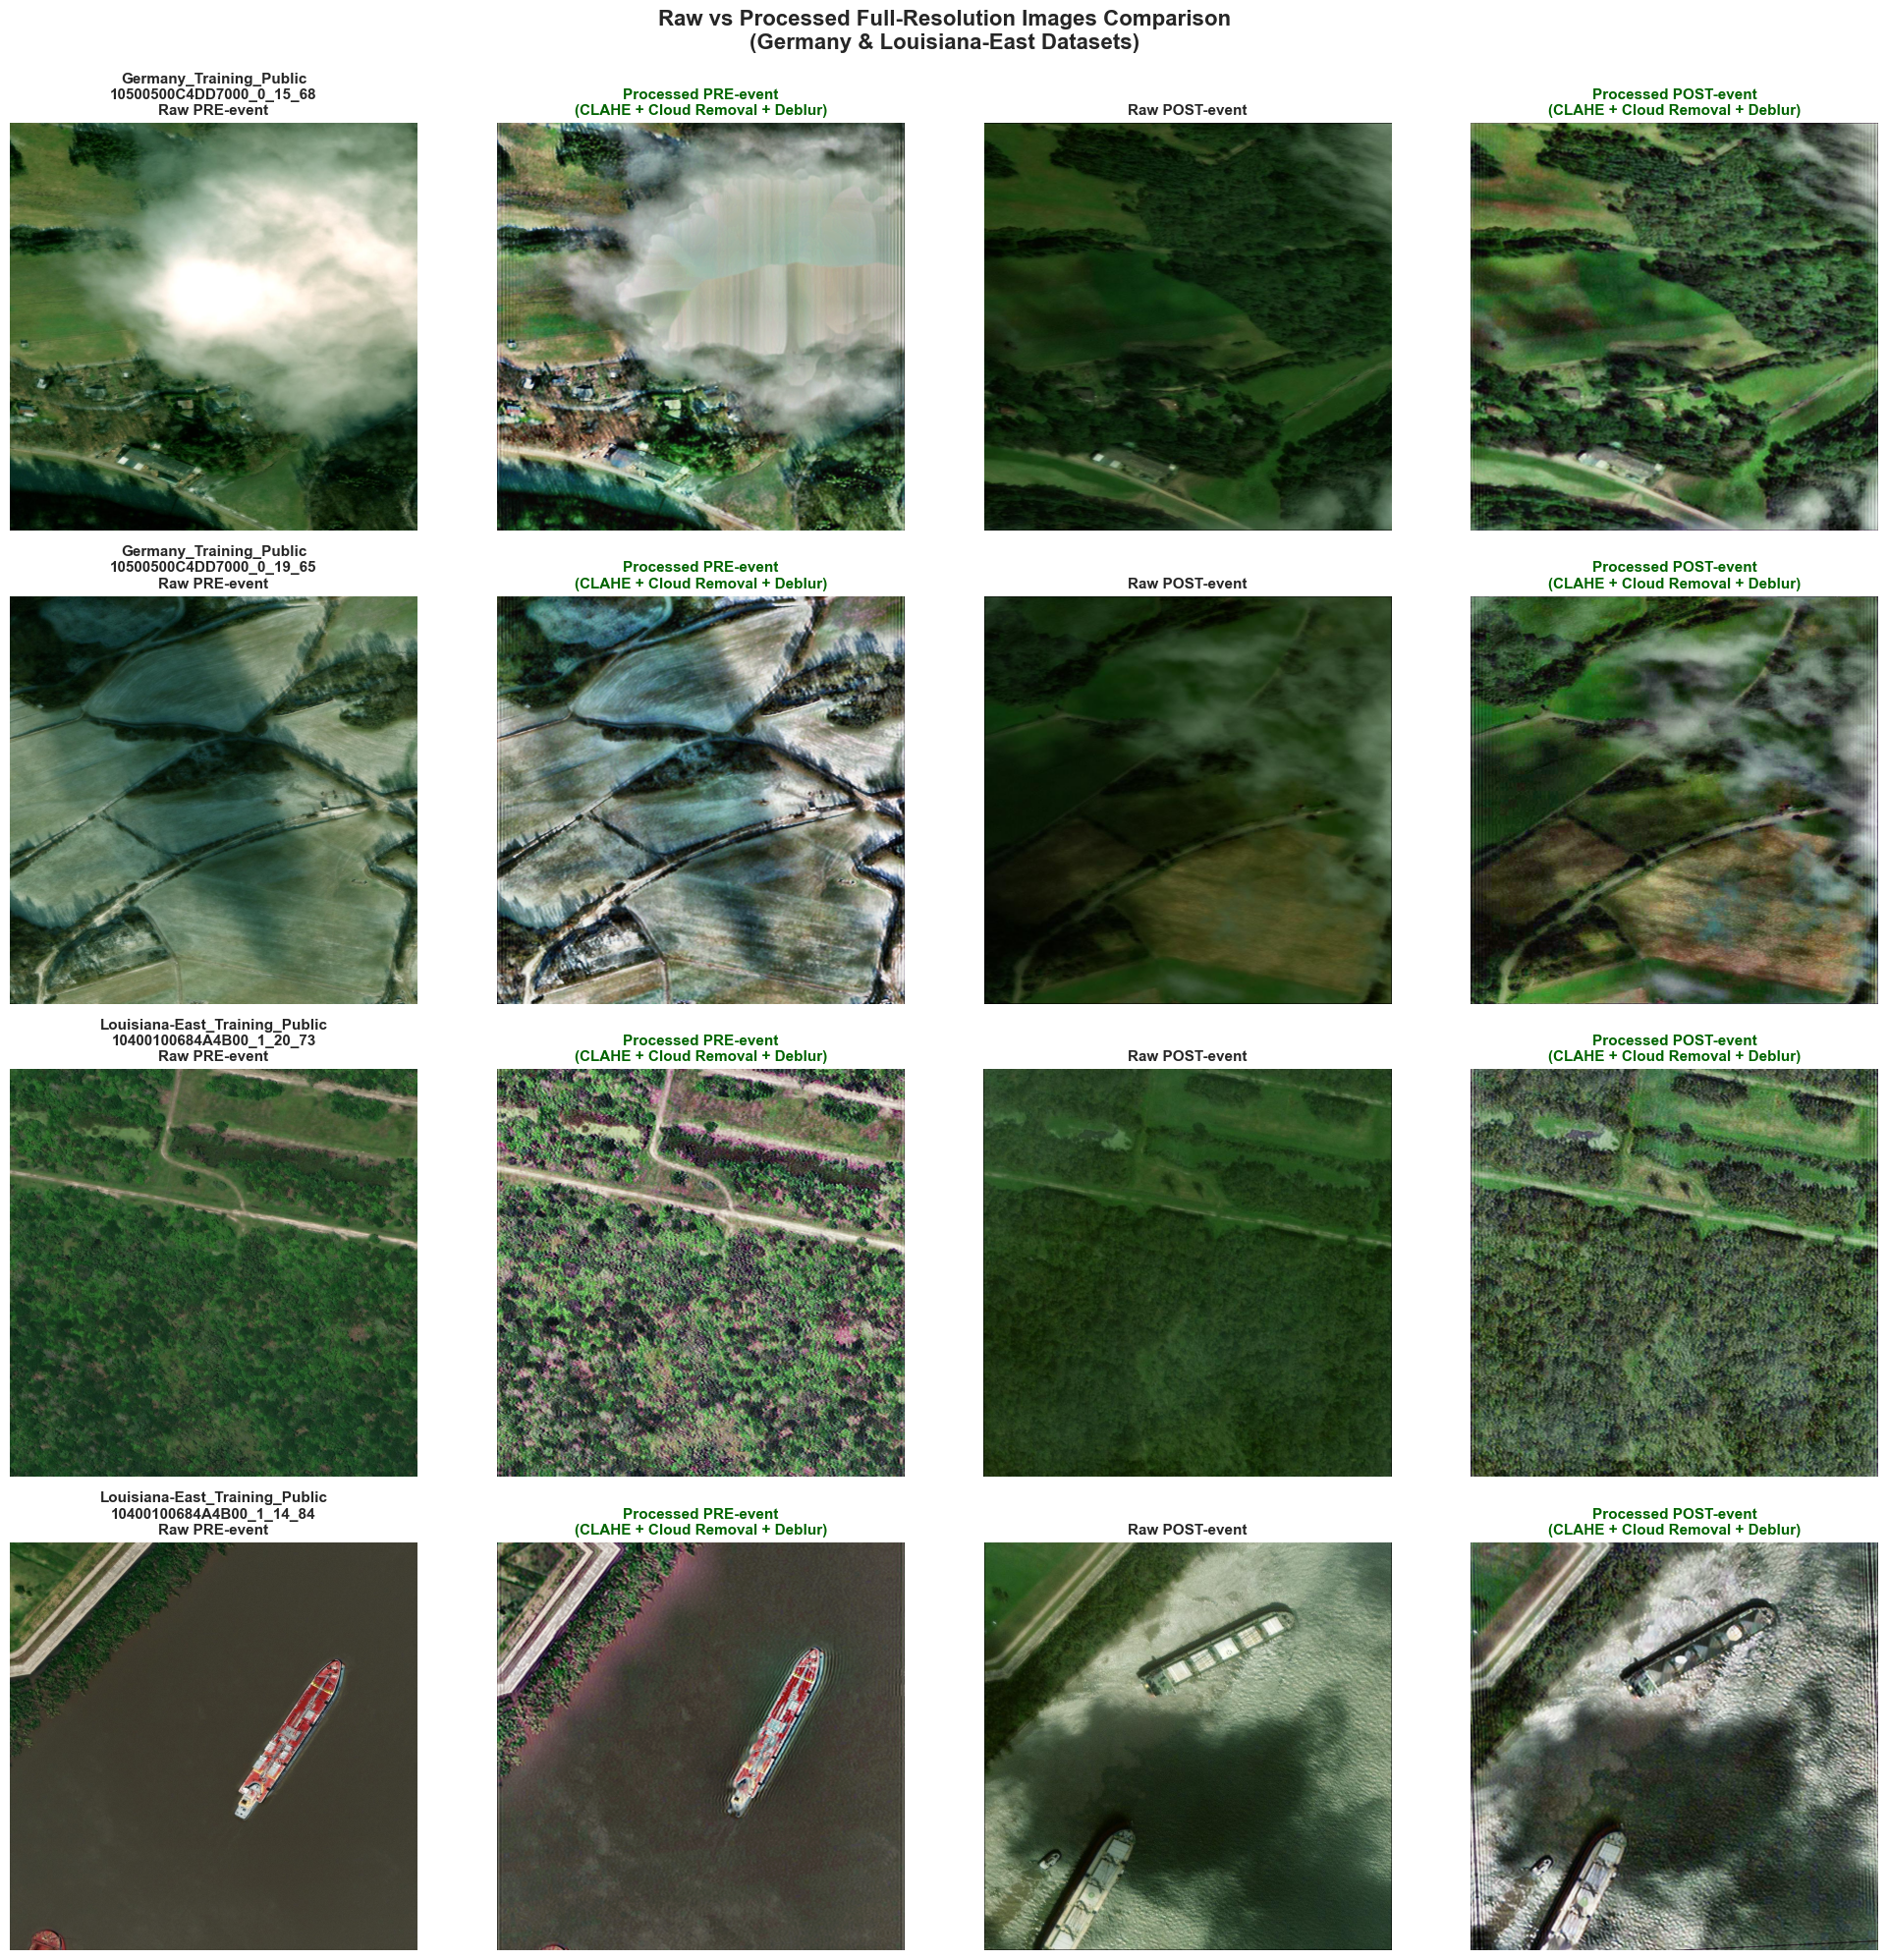


PREPROCESSING EFFECTS SUMMARY
CLAHE Enhancement: Improved local contrast and visibility
Cloud Removal: Multi-stage detection and advanced inpainting
Deblurring: Wiener + Richardson-Lucy + Unsharp masking + Edge enhancement
Format: Saved as TIF (uint16) for quality preservation


In [146]:
def load_tif_image(path):
    """Load TIF image and convert from uint16 to float32"""
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Failed to load image: {path}")
    
    # Convert BGR to RGB
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert uint16 [0, 65535] to float32 [0, 1]
    img_float = img.astype(np.float32) / 65535.0
    return img_float


def load_raw_png_image(path):
    """Load raw PNG image"""
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Failed to load image: {path}")
    
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to float32 [0, 1]
    img_float = img.astype(np.float32) / 255.0
    return img_float


# Visualize all comparison samples
if len(comparison_samples) > 0:
    n_samples = len(comparison_samples)
    
    # Create figure with subplots: 4 columns (Raw Pre, Processed Pre, Raw Post, Processed Post) x n_samples rows
    fig, axes = plt.subplots(n_samples, 4, figsize=(20, 5*n_samples))
    
    # Handle single sample case (axes won't be 2D)
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, sample in enumerate(comparison_samples):
        try:
            # Load images
            raw_pre = load_raw_png_image(sample['raw_pre'])
            raw_post = load_raw_png_image(sample['raw_post'])
            processed_pre = load_tif_image(sample['processed_pre'])
            processed_post = load_tif_image(sample['processed_post'])
            
            # Display images
            axes[idx, 0].imshow(raw_pre)
            axes[idx, 0].set_title(f"{sample['region']}\n{sample['tile']}\nRaw PRE-event", 
                                   fontsize=11, fontweight='bold')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(processed_pre)
            axes[idx, 1].set_title(f"Processed PRE-event\n(CLAHE + Cloud Removal + Deblur)", 
                                   fontsize=11, fontweight='bold', color='darkgreen')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(raw_post)
            axes[idx, 2].set_title(f"Raw POST-event", 
                                   fontsize=11, fontweight='bold')
            axes[idx, 2].axis('off')
            
            axes[idx, 3].imshow(processed_post)
            axes[idx, 3].set_title(f"Processed POST-event\n(CLAHE + Cloud Removal + Deblur)", 
                                   fontsize=11, fontweight='bold', color='darkgreen')
            axes[idx, 3].axis('off')
            
            # Calculate quality improvements
            pre_raw_metrics = calculate_quality_metrics(raw_pre)
            pre_proc_metrics = calculate_quality_metrics(processed_pre)
            post_raw_metrics = calculate_quality_metrics(raw_post)
            post_proc_metrics = calculate_quality_metrics(processed_post)
            
            print(f"\n{sample['region']} - {sample['tile']}:")
            print(f"  PRE-event improvements:")
            print(f"    Sharpness: {pre_raw_metrics['sharpness']:.1f} → {pre_proc_metrics['sharpness']:.1f} "
                  f"({((pre_proc_metrics['sharpness']/pre_raw_metrics['sharpness']-1)*100):+.1f}%)")
            print(f"    Contrast:  {pre_raw_metrics['contrast']:.3f} → {pre_proc_metrics['contrast']:.3f} "
                  f"({((pre_proc_metrics['contrast']/pre_raw_metrics['contrast']-1)*100):+.1f}%)")
            
            print(f"  POST-event improvements:")
            print(f"    Sharpness: {post_raw_metrics['sharpness']:.1f} → {post_proc_metrics['sharpness']:.1f} "
                  f"({((post_proc_metrics['sharpness']/post_raw_metrics['sharpness']-1)*100):+.1f}%)")
            print(f"    Contrast:  {post_raw_metrics['contrast']:.3f} → {post_proc_metrics['contrast']:.3f} "
                  f"({((post_proc_metrics['contrast']/post_raw_metrics['contrast']-1)*100):+.1f}%)")
            
        except Exception as e:
            print(f"Error loading sample {sample['tile']}: {e}")
            for col in range(4):
                axes[idx, col].text(0.5, 0.5, 'Error loading image', 
                                    ha='center', va='center', color='red')
                axes[idx, col].axis('off')
    
    plt.suptitle('Raw vs Processed Full-Resolution Images Comparison\n(Germany & Louisiana-East Datasets)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("PREPROCESSING EFFECTS SUMMARY")
    print("="*80)
    print("CLAHE Enhancement: Improved local contrast and visibility")
    print("Cloud Removal: Multi-stage detection and advanced inpainting")
    print("Deblurring: Wiener + Richardson-Lucy + Unsharp masking + Edge enhancement")
    print("Format: Saved as TIF (uint16) for quality preservation")
    print("="*80)
else:
    print("\n No comparison samples available. Run preprocessing pipeline first.")

## 14. Summary and Next Steps

In [ ]:
print("="*80)
print("PREPROCESSING SUMMARY")
print("="*80)
print("\nCompleted tasks:")
print("  1. Loaded and validated raw satellite imagery")
print("  2. Applied CLAHE enhancement for better contrast")
print("  3. Performed quality checks (valid pixels, clouds, darkness)")
print("  4. Extracted patches with controlled overlap")
print("  5. Oversampled flood-positive patches to address class imbalance")
print("  6. Created geo-stratified train/val/test splits")
print("  7. Exported processed data in .npy format")
print("\nKey outcomes:")
print("  - Balanced dataset with 40-50% flood-positive patches")
print("  - 512x512 patches optimized for CV models")
print("  - 6-channel input (3 pre + 3 post event)")
print("  - No spatial leakage between train/val/test")
print("\nNext steps (Phase 3):")
print("  - Implement U-Net++, DeepLabV3+, and SegFormer models")
print("  - Design PyTorch Dataset and DataLoader")
print("  - Set up training pipeline with class-weighted loss")
print("  - Configure multi-scale training and validation")
print("="*80)